# **Set Up Environment and Install Libraries**

In [1]:
# Install required libraries
!pip install torch torchvision matplotlib

# Clone the CycleGAN repository
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git


Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516 (from 1)
Receiving objects: 100% (2516/2516), 8.20 MiB | 29.36 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.


# **Load the Datasets**

Kaggle allows you to attach datasets directly to your notebook. Ensure that:

Attach the Weather Dataset from Kaggle: jehanbhathena/weather-dataset.

Attach the Cityscapes Dataset: chrisviviers/cityscapes-leftimg8bit-trainvaltest.

After attaching, the datasets will be available in /kaggle/input


In [1]:
import os
import shutil

# Paths for the datasets
weather_path = '/kaggle/input/weather-dataset/dataset'
cityscapes_path = '/kaggle/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit'

# Create CycleGAN dataset structure
os.makedirs('./datasets/day2night/trainA', exist_ok=True)
os.makedirs('./datasets/day2night/trainB', exist_ok=True)
os.makedirs('./datasets/day2night/testA', exist_ok=True)
os.makedirs('./datasets/day2night/testB', exist_ok=True)

# Move rainy images from Weather Dataset to trainB
rainy_images = os.path.join(weather_path, 'rain')
for file in os.listdir(rainy_images):
    shutil.copy(os.path.join(rainy_images, file), './datasets/day2night/trainB/')

# Move clear images from Cityscapes Dataset to trainA
cityscapes_images = os.path.join(cityscapes_path, 'train')
for root, _, files in os.walk(cityscapes_images):
    for file in files:
        if file.endswith('.png'):
            shutil.copy(os.path.join(root, file), './datasets/day2night/trainA/')

# Optionally split some images into test sets
trainA_files = os.listdir('./datasets/day2night/trainA')
trainB_files = os.listdir('./datasets/day2night/trainB')

for i in range(100):  # Move 100 images to test set
    shutil.move(f'./datasets/day2night/trainA/{trainA_files[i]}', './datasets/day2night/testA/')
    shutil.move(f'./datasets/day2night/trainB/{trainB_files[i]}', './datasets/day2night/testB/')


# **Train the CycleGAN Model**

Use the training script with the updated dataset path. 

This will save the model checkpoints in ./checkpoints

In [6]:
!pip install -r /kaggle/working/pytorch-CycleGAN-and-pix2pix/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408196 sha256=64d2f81a4ca4907351482eb1f4d4b9afd72485390cadd02446053fd57be849e9
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built visdom


In [ ]:
# !cd pytorch-CycleGAN-and-pix2pix
# !python /kaggle/working/pytorch-CycleGAN-and-pix2pix/train.py --dataroot ./datasets/day2night --name clear2rainy_cyclegan --model cycle_gan --gpu_ids 0

In [26]:
main_train_py = """
import time
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer

if __name__ == '__main__':
    opt = TrainOptions().parse()   # get training options
    dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
    dataset_size = len(dataset)    # get the number of images in the dataset.
    print('The number of training images = %d' % dataset_size)

    model = create_model(opt)      # create a model given opt.model and other options
    model.setup(opt)               # regular setup: load and print networks; create schedulers
    visualizer = Visualizer(opt)   # create a visualizer that display/save images and plots
    total_iters = 0                # the total number of training iterations

    for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):    # outer loop for different epochs; we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>
        epoch_start_time = time.time()  # timer for entire epoch
        iter_data_time = time.time()    # timer for data loading per iteration
        epoch_iter = 0                  # the number of training iterations in current epoch, reset to 0 every epoch
        visualizer.reset()              # reset the visualizer: make sure it saves the results to HTML at least once every epoch
        model.update_learning_rate()    # update learning rates in the beginning of every epoch.
        for i, data in enumerate(dataset):  # inner loop within one epoch
            iter_start_time = time.time()  # timer for computation per iteration
            if total_iters % opt.print_freq == 0:
                t_data = iter_start_time - iter_data_time

            total_iters += opt.batch_size
            epoch_iter += opt.batch_size
            model.set_input(data)         # unpack data from dataset and apply preprocessing
            model.optimize_parameters()   # calculate loss functions, get gradients, update network weights

            if total_iters % opt.display_freq == 0:   # display images on visdom and save images to a HTML file
                save_result = total_iters % opt.update_html_freq == 0
                model.compute_visuals()
                visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

            if total_iters % opt.print_freq == 0:    # print training losses and save logging information to the disk
                losses = model.get_current_losses()
                t_comp = (time.time() - iter_start_time) / opt.batch_size
                visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)
                if opt.display_id > 0:
                    visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, losses)

            if total_iters % opt.save_latest_freq == 0:   # cache our latest model every <save_latest_freq> iterations
                print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
                save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
                model.save_networks(save_suffix)

            iter_data_time = time.time()
        if epoch % opt.save_epoch_freq == 0:              # cache our model every <save_epoch_freq> epochs
            print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
            model.save_networks('latest')
            model.save_networks(epoch)

        print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))

"""

# Save the content to train.py in the working directory
with open("train.py", "w") as f:
    f.write(main_train_py)

print("writing to train.py complete")


writing to train.py complete


In [22]:
updated_train_py = """
import time
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer
import torch

def main():
    opt = TrainOptions().parse()  # Get training options
    dataset = create_dataset(opt)  # Create the dataset
    dataset_size = len(dataset)
    print(f'The number of training images = {dataset_size}')

    model = create_model(opt)  # Create and initialize the CycleGAN model

    # Multi-GPU support
    if len(opt.gpu_ids) > 1:
        model.netG_A = torch.nn.DataParallel(model.netG_A, device_ids=opt.gpu_ids)
        model.netG_B = torch.nn.DataParallel(model.netG_B, device_ids=opt.gpu_ids)
        model.netD_A = torch.nn.DataParallel(model.netD_A, device_ids=opt.gpu_ids)
        model.netD_B = torch.nn.DataParallel(model.netD_B, device_ids=opt.gpu_ids)

    model.setup(opt)  # Load and set up the model
    visualizer = Visualizer(opt)  # Visualizer to monitor training
    total_iters = 0  # Total iterations across epochs

    for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):
        epoch_start_time = time.time()  # Timer for the epoch
        iter_data_time = time.time()  # Timer for data loading
        epoch_iter = 0  # Iterations within this epoch

        for i, data in enumerate(dataset):
            iter_start_time = time.time()  # Timer for iteration
            if total_iters % opt.print_freq == 0:
                t_data = iter_start_time - iter_data_time
            total_iters += opt.batch_size
            epoch_iter += opt.batch_size
        
            # Move data to GPUs
            if isinstance(data, list):
                data = [item.to(model.device) for item in data]
                real_A, real_B = data
                data = {'A': real_A, 'B': real_B}  # Convert to dict
            elif isinstance(data, dict):
                data = {k: v.to(model.device) for k, v in data.items()}
            else:
                raise TypeError(f"Unsupported data format: {type(data)}")
        
            # Training process
            model.set_input(data)
            model.optimize_parameters()
        
            if total_iters % opt.display_freq == 0:
                visualizer.display_current_results(model.get_current_visuals(), epoch, save_result=False)
        
            if total_iters % opt.print_freq == 0:
                losses = model.get_current_losses()
                t_comp = (time.time() - iter_start_time) / opt.batch_size
                visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)
                if opt.display_id > 0:
                    visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, losses)
        
            iter_data_time = time.time()

        if epoch % opt.save_epoch_freq == 0:
            print(f'Saving the model at the end of epoch {epoch}, total_iters {total_iters}')
            model.save_networks('latest')
            model.save_networks(epoch)

        print(f'End of epoch {epoch} / {opt.n_epochs + opt.n_epochs_decay} \\t Time Taken: {time.time() - epoch_start_time} sec')
        model.update_learning_rate()  # Update learning rates at the end of every epoch

if __name__ == '__main__':
    main()
"""

# Save the content to train.py in the working directory
with open("train.py", "w") as f:
    f.write(updated_train_py)

print("writing to train.py complete")


writing to train.py complete


In [27]:
!cp train.py /kaggle/working/pytorch-CycleGAN-and-pix2pix/
print("updated train.py")

updated train.py


In [ ]:
!python pytorch-CycleGAN-and-pix2pix/train.py \
    --dataroot ./datasets/day2night \
    --name clear2rainy_cyclegan \
    --model cycle_gan \
    --gpu_ids 0,1 \
    --display_id 0  # Disable Visdom visualization


In [ ]:
!python  pytorch-CycleGAN-and-pix2pix/train.py --gpu_ids 0,1 --dataroot ./datasets/day2night --name clear2rainy_cyclegan --model cycle_gan --display_id 0

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./datasets/day2night          	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 0                             	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
 

# **Test the Model**

Generate transformed images to evaluate the results.

In [ ]:
!python test.py --dataroot ./datasets/day2night --name clear2rainy_cyclegan --model cycle_gan --gpu_ids 0

# **Save the Model**

Save the trained model checkpoint as a Kaggle Dataset or download it directly.

In [ ]:
# Compress the checkpoints to save them
!zip -r clear2rainy_cyclegan_checkpoints.zip ./pytorch-CycleGAN-and-pix2pix/checkpoints/clear2rainy_cyclegan

# Download the compressed file (optional)
from IPython.display import FileLink
FileLink('./clear2rainy_cyclegan_checkpoints.zip')

.

.

.

Trying multi GPU code clear to rainy

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import cv2
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Check for Multiple GPUs
device_count = torch.cuda.device_count()
device = torch.device("cuda:0" if device_count > 0 else "cpu")

# Print if multiple GPUs are available
if device_count > 1:
    print(f"Using {device_count} GPUs!")
else:
    print("Using a single GPU or CPU.")

# Define Dataset class
class RainDataset(Dataset):
    def __init__(self, clear_image_dir, rainy_image_dir, transform=None):
        """
        Initializes the dataset by loading the file paths for clear and rainy images.
        """
        self.clear_image_dir = clear_image_dir
        self.rainy_image_dir = rainy_image_dir
        self.transform = transform
        self.clear_images = [
            f
            for f in os.listdir(clear_image_dir)
            if f.endswith((".png", ".jpg", ".jpeg"))
        ]
        self.rainy_images = [
            f
            for f in os.listdir(rainy_image_dir)
            if f.endswith((".png", ".jpg", ".jpeg"))
        ]

        # Trim the dataset to the minimum size between the two directories
        min_size = min(len(self.clear_images), len(self.rainy_images))
        self.clear_images = self.clear_images[:min_size]
        self.rainy_images = self.rainy_images[:min_size]

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.clear_images)

    def __getitem__(self, index):
        """
        Loads the clear image and the corresponding rainy image at the given index.
        """
        clear_image_path = os.path.join(self.clear_image_dir, self.clear_images[index])
        rainy_image_path = os.path.join(self.rainy_image_dir, self.rainy_images[index])

        clear_image = cv2.imread(clear_image_path)
        rainy_image = cv2.imread(rainy_image_path)

        # Convert BGR (OpenCV format) to RGB
        clear_image = cv2.cvtColor(clear_image, cv2.COLOR_BGR2RGB)
        rainy_image = cv2.cvtColor(rainy_image, cv2.COLOR_BGR2RGB)

        # Apply any specified transformations (such as resizing and normalization)
        if self.transform:
            clear_image = self.transform(clear_image)
            rainy_image = self.transform(rainy_image)

        return clear_image, rainy_image

# Define Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder: Extract features from the clear image
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # Decoder: Reconstruct the image with added rain
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3),
            nn.Tanh(),  # Using Tanh to scale output between -1 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        # Resize the output to match the size of the input clear image
        x = nn.functional.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)

        return x
# Define Discriminator class with fix
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # The input has 6 channels: 3 channels for the clear image and 3 for the rainy image
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output size: (B, 64, H/2, W/2)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output size: (B, 128, H/4, W/4)
        )

        # Calculate the correct input size for the fully connected layer
        self.fc_input_size = self._get_fc_input_size(256)  # Assume input image size is 256x256
        self.fc = nn.Linear(self.fc_input_size, 1)  # Fully connected layer
        self.sigmoid = nn.Sigmoid()

    def _get_fc_input_size(self, image_size):
        # Pass a dummy tensor through the network to compute the flattened size
        dummy_input = torch.zeros(1, 6, image_size, image_size)  # 6 channels, 256x256 image
        output = self.model(dummy_input)
        return output.view(1, -1).size(1)  # Flatten and return the number of features

    def forward(self, x):
        # Pass through convolutional layers
        x = self.model(x)
        
        # Flatten the tensor and pass through fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        # Apply sigmoid to get a probability between 0 and 1
        x = self.sigmoid(x)
        return x

# Initialize Models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Use DataParallel if multiple GPUs are available
if device_count > 1:
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)

# Loss functions and optimizers
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.001)

# Dataset and DataLoader setup
image_dir = "/kaggle/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/train/aachen"
rain_dir = "/kaggle/input/weather-dataset/dataset/rain"
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((256, 256)), transforms.ToTensor()])
dataset = RainDataset(image_dir, rain_dir, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# For logging and visualization
losses_d = []
losses_g = []

# Create Plotly figure for losses visualization
fig_loss = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.1)
fig_loss.add_trace(go.Scatter(x=[], y=[], mode='lines+markers', name="Loss D", line=dict(color='red')), row=1, col=1)
fig_loss.add_trace(go.Scatter(x=[], y=[], mode='lines+markers', name="Loss G", line=dict(color='blue')), row=1, col=1)
fig_loss.update_layout(title="Discriminator and Generator Losses", xaxis_title="Epoch", yaxis_title="Loss", template="plotly_dark")

# Training Loop
for epoch in range(100):  # Number of epochs
    for i, (clear_images, rainy_images) in enumerate(dataloader):
        clear_images, rainy_images = clear_images.to(device), rainy_images.to(device)

        # Train Discriminator with real images (clear + rainy)
        real_images = torch.cat((clear_images, rainy_images), 1)
        labels_real = torch.ones((clear_images.size(0), 1)).to(device)  # Use clear_images.size(0) for batch size
        outputs_real = discriminator(real_images)
        loss_d_real = criterion(outputs_real, labels_real)

        # Train Discriminator with fake images (generated rainy images)
        fake_rain = generator(clear_images)
        fake_images = torch.cat((clear_images, fake_rain.detach()), 1)
        labels_fake = torch.zeros((clear_images.size(0), 1)).to(device)  # Use clear_images.size(0) for batch size
        outputs_fake = discriminator(fake_images)
        loss_d_fake = criterion(outputs_fake, labels_fake)

        # Total Discriminator loss
        loss_d = (loss_d_real + loss_d_fake) / 2
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        # Train Generator to fool Discriminator
        fake_images = torch.cat((clear_images, fake_rain), 1)
        labels_fake = torch.ones((32, 1)).to(device)
        outputs_fake = discriminator(fake_images)
        loss_g = criterion(outputs_fake, labels_fake)
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        # Log losses
        losses_d.append(loss_d.item())
        losses_g.append(loss_g.item())

        # Print out the losses for the current batch
        print(f"Epoch {epoch+1}, Batch {i+1}, Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

    # Update Plotly Loss graph after each epoch
    fig_loss.data[0].x += [epoch+1]  # Add epoch number to x-axis
    fig_loss.data[0].y += [loss_d.item()]  # Add discriminator loss
    fig_loss.data[1].x += [epoch+1]  # Add epoch number to x-axis
    fig_loss.data[1].y += [loss_g.item()]  # Add generator loss
    fig_loss.show()

    # Generate and plot an example generated image after each epoch
    with torch.no_grad():
        sample_image = generator(clear_images[:1].to(device))  # Generate a sample image
        sample_image = sample_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convert to numpy for display

        # Display the generated image using matplotlib
        plt.imshow(sample_image)
        plt.title(f"Generated Rainy Image - Epoch {epoch+1}")
        plt.axis('off')
        plt.show()

    # Save model checkpoints after each epoch
    torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
    torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")


Using 2 GPUs!
Epoch 1, Batch 1, Loss D: 0.6929, Loss G: 0.6606
Epoch 1, Batch 2, Loss D: 0.4541, Loss G: 8.5643
Epoch 1, Batch 3, Loss D: 1.9449, Loss G: 2.0460
Epoch 1, Batch 4, Loss D: 0.0942, Loss G: 0.2257
Epoch 1, Batch 5, Loss D: 1.3576, Loss G: 1.5626


ValueError: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([14, 1])) is deprecated. Please ensure they have the same size.

Using 2 GPUs!
Epoch 1, Batch 1, Loss D: 0.6928, Loss G: 0.0331
Epoch 1, Batch 2, Loss D: 1.7825, Loss G: 6.3080
Epoch 1, Batch 3, Loss D: 3.7643, Loss G: 3.4041
Epoch 1, Batch 4, Loss D: 0.9048, Loss G: 1.2657
Epoch 1, Batch 5, Loss D: 0.2044, Loss G: 0.9123
Epoch 1, Batch 6, Loss D: 0.2998, Loss G: 1.6420


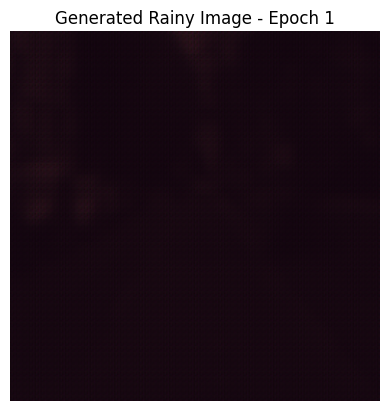

Epoch 2, Batch 1, Loss D: 0.1565, Loss G: 3.1015
Epoch 2, Batch 2, Loss D: 0.0673, Loss G: 4.7536
Epoch 2, Batch 3, Loss D: 0.1121, Loss G: 7.1121
Epoch 2, Batch 4, Loss D: 0.6445, Loss G: 11.2321
Epoch 2, Batch 5, Loss D: 5.0700, Loss G: 1.1674
Epoch 2, Batch 6, Loss D: 4.6112, Loss G: 3.8762


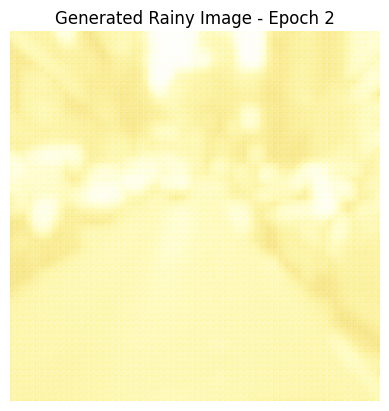

Epoch 3, Batch 1, Loss D: 2.0685, Loss G: 1.4659
Epoch 3, Batch 2, Loss D: 0.3526, Loss G: 0.0064
Epoch 3, Batch 3, Loss D: 2.6450, Loss G: 0.1758
Epoch 3, Batch 4, Loss D: 0.9884, Loss G: 3.5783
Epoch 3, Batch 5, Loss D: 0.1107, Loss G: 6.1372
Epoch 3, Batch 6, Loss D: 0.4280, Loss G: 6.8964


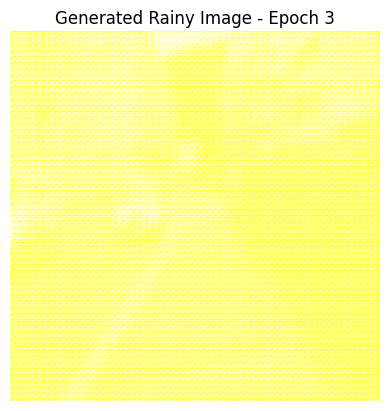

Epoch 4, Batch 1, Loss D: 0.2983, Loss G: 6.6024
Epoch 4, Batch 2, Loss D: 0.4539, Loss G: 5.6600
Epoch 4, Batch 3, Loss D: 0.1728, Loss G: 4.3132
Epoch 4, Batch 4, Loss D: 0.0914, Loss G: 2.8226
Epoch 4, Batch 5, Loss D: 0.0544, Loss G: 1.7692
Epoch 4, Batch 6, Loss D: 0.1716, Loss G: 1.5919


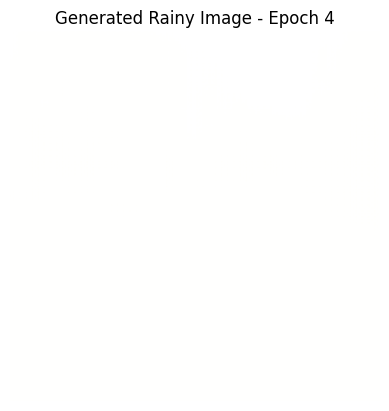

Epoch 5, Batch 1, Loss D: 0.1139, Loss G: 2.6480
Epoch 5, Batch 2, Loss D: 0.0555, Loss G: 3.4858
Epoch 5, Batch 3, Loss D: 0.0326, Loss G: 4.5684
Epoch 5, Batch 4, Loss D: 0.0133, Loss G: 5.3156
Epoch 5, Batch 5, Loss D: 0.0138, Loss G: 6.3102
Epoch 5, Batch 6, Loss D: 0.0014, Loss G: 6.9385


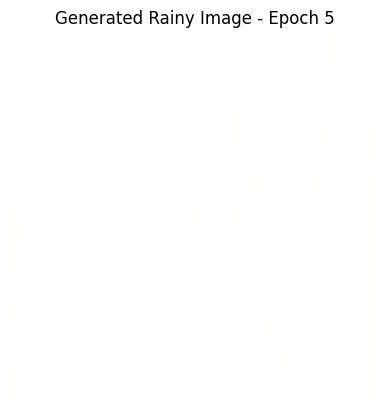

Epoch 6, Batch 1, Loss D: 0.0105, Loss G: 7.5867
Epoch 6, Batch 2, Loss D: 0.0019, Loss G: 7.7909
Epoch 6, Batch 3, Loss D: 0.0062, Loss G: 8.3180
Epoch 6, Batch 4, Loss D: 0.0149, Loss G: 8.4384
Epoch 6, Batch 5, Loss D: 0.0088, Loss G: 8.6418
Epoch 6, Batch 6, Loss D: 0.0003, Loss G: 8.8513


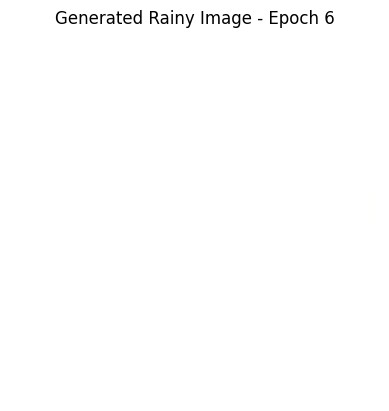

Epoch 7, Batch 1, Loss D: 0.0003, Loss G: 8.5518
Epoch 7, Batch 2, Loss D: 0.0013, Loss G: 8.8274
Epoch 7, Batch 3, Loss D: 0.0001, Loss G: 8.7386
Epoch 7, Batch 4, Loss D: 0.0001, Loss G: 8.7523
Epoch 7, Batch 5, Loss D: 0.0001, Loss G: 8.6454
Epoch 7, Batch 6, Loss D: 0.0002, Loss G: 8.4691


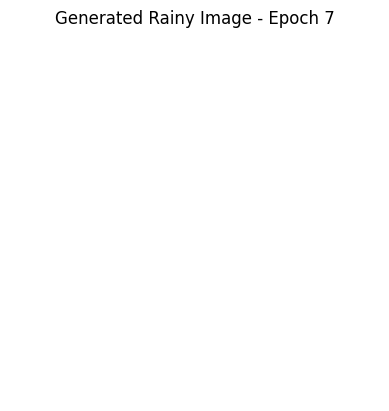

Epoch 8, Batch 1, Loss D: 0.0002, Loss G: 8.3169
Epoch 8, Batch 2, Loss D: 0.0002, Loss G: 8.2520
Epoch 8, Batch 3, Loss D: 0.0004, Loss G: 8.0027
Epoch 8, Batch 4, Loss D: 0.0002, Loss G: 8.2448
Epoch 8, Batch 5, Loss D: 0.0005, Loss G: 8.0891
Epoch 8, Batch 6, Loss D: 0.0004, Loss G: 7.8558


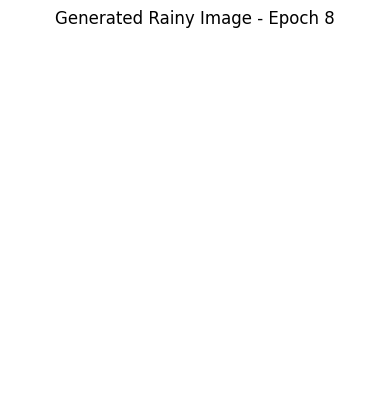

Epoch 9, Batch 1, Loss D: 0.0007, Loss G: 7.9834
Epoch 9, Batch 2, Loss D: 0.0004, Loss G: 8.1812
Epoch 9, Batch 3, Loss D: 0.0003, Loss G: 8.2778
Epoch 9, Batch 4, Loss D: 0.0005, Loss G: 8.0663
Epoch 9, Batch 5, Loss D: 0.0002, Loss G: 8.6164
Epoch 9, Batch 6, Loss D: 0.0006, Loss G: 8.2867


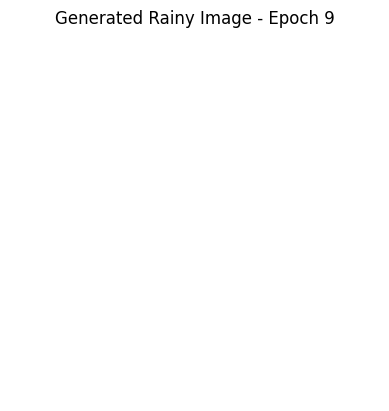

Epoch 10, Batch 1, Loss D: 0.0004, Loss G: 8.4620
Epoch 10, Batch 2, Loss D: 0.0002, Loss G: 9.0078
Epoch 10, Batch 3, Loss D: 0.0001, Loss G: 9.2033
Epoch 10, Batch 4, Loss D: 0.0001, Loss G: 9.0722
Epoch 10, Batch 5, Loss D: 0.0003, Loss G: 9.1063
Epoch 10, Batch 6, Loss D: 0.0002, Loss G: 9.1933


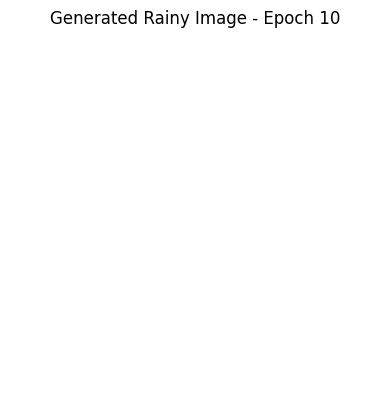

Epoch 11, Batch 1, Loss D: 0.0002, Loss G: 9.3950
Epoch 11, Batch 2, Loss D: 0.0001, Loss G: 9.4434
Epoch 11, Batch 3, Loss D: 0.0001, Loss G: 9.6681
Epoch 11, Batch 4, Loss D: 0.0000, Loss G: 9.8965
Epoch 11, Batch 5, Loss D: 0.0001, Loss G: 9.9170
Epoch 11, Batch 6, Loss D: 0.0000, Loss G: 10.2243


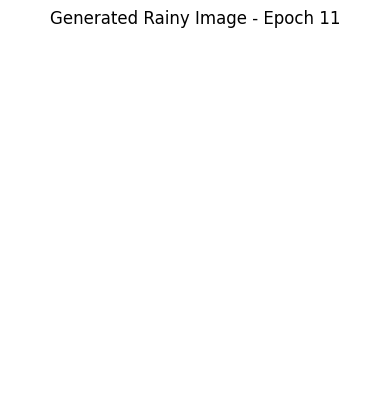

KeyboardInterrupt: 

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Check for multiple GPUs
device_count = torch.cuda.device_count()
device = torch.device("cuda:0" if device_count > 0 else "cpu")

# Print GPU status
if device_count > 1:
    print(f"Using {device_count} GPUs!")
else:
    print("Using a single GPU or CPU.")

# Dataset class for loading images
class RainDataset(Dataset):
    def __init__(self, clear_image_dir, rainy_image_dir, transform=None):
        self.clear_image_dir = clear_image_dir
        self.rainy_image_dir = rainy_image_dir
        self.transform = transform
        self.clear_images = [f for f in os.listdir(clear_image_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
        self.rainy_images = [f for f in os.listdir(rainy_image_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
        
        min_size = min(len(self.clear_images), len(self.rainy_images))
        self.clear_images = self.clear_images[:min_size]
        self.rainy_images = self.rainy_images[:min_size]

    def __len__(self):
        return len(self.clear_images)

    def __getitem__(self, index):
        clear_image_path = os.path.join(self.clear_image_dir, self.clear_images[index])
        rainy_image_path = os.path.join(self.rainy_image_dir, self.rainy_images[index])

        clear_image = cv2.imread(clear_image_path)
        rainy_image = cv2.imread(rainy_image_path)

        clear_image = cv2.cvtColor(clear_image, cv2.COLOR_BGR2RGB)
        rainy_image = cv2.cvtColor(rainy_image, cv2.COLOR_BGR2RGB)

        if self.transform:
            clear_image = self.transform(clear_image)
            rainy_image = self.transform(rainy_image)

        return clear_image, rainy_image


# Generator: Adds rain to the input clear image
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3),
            nn.Tanh(),  # Output with values between -1 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = nn.functional.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)  # Resize to match input size
        return x


# Discriminator: Determines if an image is real or fake
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_input_size = self._get_fc_input_size(256)  # Assuming input size 256x256
        self.fc = nn.Linear(self.fc_input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def _get_fc_input_size(self, image_size):
        dummy_input = torch.zeros(1, 6, image_size, image_size)
        output = self.model(dummy_input)
        return output.view(1, -1).size(1)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


# Initialize models and move to GPU
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Use DataParallel if multiple GPUs are available
if device_count > 1:
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)

# Loss functions and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# Dataset and DataLoader setup
clear_image_dir = "/kaggle/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/train/aachen"
rainy_image_dir = "/kaggle/input/weather-dataset/dataset/rain"
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((256, 256)), transforms.ToTensor()])
dataset = RainDataset(clear_image_dir, rainy_image_dir, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training loop
for epoch in range(100):  # Total epochs
    for i, (clear_images, rainy_images) in enumerate(dataloader):
        clear_images, rainy_images = clear_images.to(device), rainy_images.to(device)

        # Train Discriminator with real images (clear + rainy)
        real_images = torch.cat((clear_images, rainy_images), 1)
        labels_real = torch.ones(clear_images.size(0), 1).to(device)
        outputs_real = discriminator(real_images)
        loss_d_real = criterion(outputs_real.view(-1), labels_real.view(-1))

        # Train Discriminator with fake images (generated rainy images)
        fake_rain = generator(clear_images)
        fake_images = torch.cat((clear_images, fake_rain.detach()), 1)
        labels_fake = torch.zeros(clear_images.size(0), 1).to(device)
        outputs_fake = discriminator(fake_images)
        loss_d_fake = criterion(outputs_fake.view(-1), labels_fake.view(-1))

        # Total Discriminator loss
        loss_d = (loss_d_real + loss_d_fake) / 2
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        # Train Generator to fool Discriminator
        fake_images = torch.cat((clear_images, fake_rain), 1)
        labels_fake = torch.ones(clear_images.size(0), 1).to(device)
        outputs_fake = discriminator(fake_images)
        loss_g = criterion(outputs_fake.view(-1), labels_fake.view(-1))
        
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        # Print losses for each batch
        print(f"Epoch {epoch+1}, Batch {i+1}, Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

    # Save model checkpoints after each epoch
    torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
    torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")

    # Generate and plot an example generated image after each epoch
    with torch.no_grad():
        sample_image = generator(clear_images[:1].to(device))  # Generate a sample image
        sample_image = sample_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convert to numpy for display

        # Display the generated image using matplotlib
        plt.imshow(sample_image)
        plt.title(f"Generated Rainy Image - Epoch {epoch+1}")
        plt.axis('off')
        plt.show()


Using 2 GPUs!
Epoch 1, Batch 1, Loss D: 0.6929, Loss G: 0.5093
Epoch 1, Batch 2, Loss D: 0.6515, Loss G: 1.1756
Epoch 1, Batch 3, Loss D: 0.5891, Loss G: 0.7098
Epoch 1, Batch 4, Loss D: 0.4723, Loss G: 1.1428
Epoch 1, Batch 5, Loss D: 0.2770, Loss G: 2.0651
Epoch 1, Batch 6, Loss D: 0.1330, Loss G: 2.5055


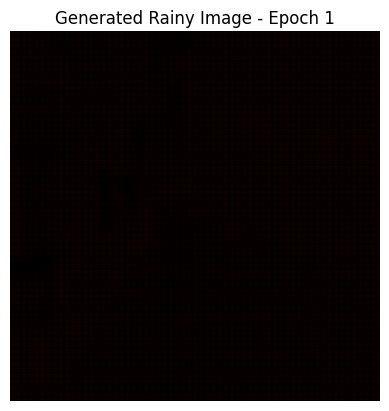

Epoch 2, Batch 1, Loss D: 0.1033, Loss G: 2.7519
Epoch 2, Batch 2, Loss D: 0.0616, Loss G: 4.8610
Epoch 2, Batch 3, Loss D: 0.0679, Loss G: 3.0704
Epoch 2, Batch 4, Loss D: 0.2915, Loss G: 7.4934
Epoch 2, Batch 5, Loss D: 0.3677, Loss G: 5.1978
Epoch 2, Batch 6, Loss D: 0.0546, Loss G: 3.4993


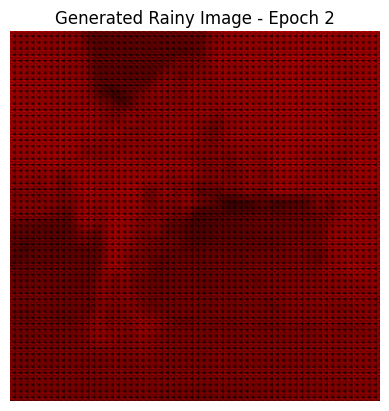

Epoch 3, Batch 1, Loss D: 0.6637, Loss G: 9.7249
Epoch 3, Batch 2, Loss D: 0.1395, Loss G: 10.8992
Epoch 3, Batch 3, Loss D: 0.0429, Loss G: 10.0368
Epoch 3, Batch 4, Loss D: 0.0261, Loss G: 7.9812
Epoch 3, Batch 5, Loss D: 0.0005, Loss G: 5.6744
Epoch 3, Batch 6, Loss D: 0.0121, Loss G: 4.8714


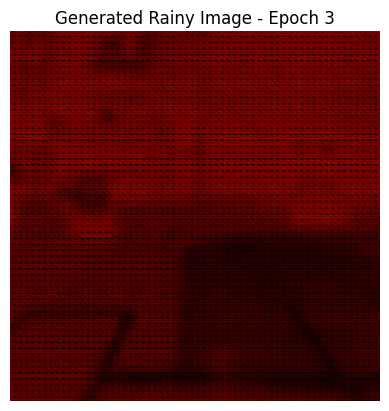

Epoch 4, Batch 1, Loss D: 0.0618, Loss G: 8.0192
Epoch 4, Batch 2, Loss D: 0.0027, Loss G: 8.1376
Epoch 4, Batch 3, Loss D: 0.0029, Loss G: 7.0259
Epoch 4, Batch 4, Loss D: 0.0133, Loss G: 5.6057
Epoch 4, Batch 5, Loss D: 0.0383, Loss G: 3.6844
Epoch 4, Batch 6, Loss D: 0.0413, Loss G: 6.8621


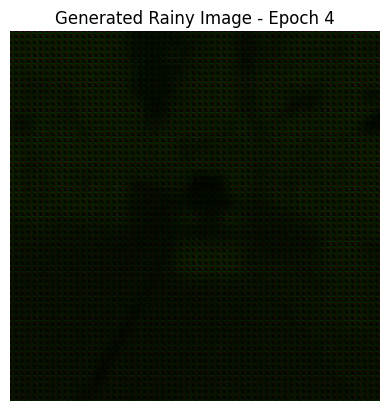

Epoch 5, Batch 1, Loss D: 0.0240, Loss G: 6.6294
Epoch 5, Batch 2, Loss D: 0.0073, Loss G: 5.2992
Epoch 5, Batch 3, Loss D: 0.0242, Loss G: 6.3378
Epoch 5, Batch 4, Loss D: 0.0492, Loss G: 7.2317
Epoch 5, Batch 5, Loss D: 0.1713, Loss G: 9.1879
Epoch 5, Batch 6, Loss D: 0.1242, Loss G: 0.2890


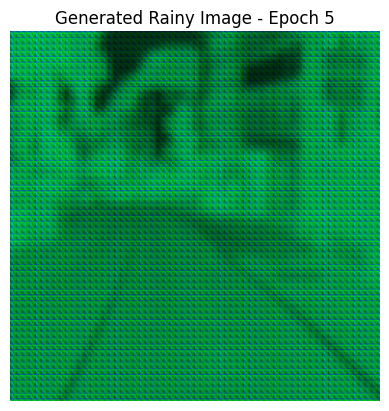

Epoch 6, Batch 1, Loss D: 5.8334, Loss G: 17.2829
Epoch 6, Batch 2, Loss D: 2.6075, Loss G: 11.8457
Epoch 6, Batch 3, Loss D: 0.3294, Loss G: 7.5568
Epoch 6, Batch 4, Loss D: 0.2725, Loss G: 3.9069
Epoch 6, Batch 5, Loss D: 0.0605, Loss G: 1.9409
Epoch 6, Batch 6, Loss D: 0.1414, Loss G: 3.1453


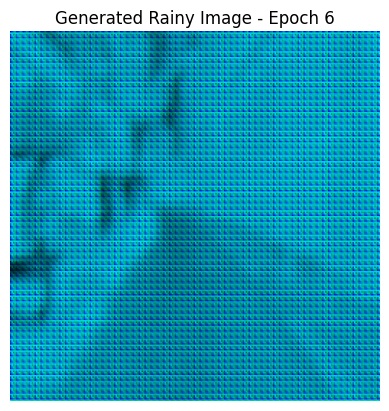

Epoch 7, Batch 1, Loss D: 0.0810, Loss G: 4.4620
Epoch 7, Batch 2, Loss D: 0.0996, Loss G: 4.6851
Epoch 7, Batch 3, Loss D: 0.3012, Loss G: 8.9060
Epoch 7, Batch 4, Loss D: 0.2417, Loss G: 9.7713
Epoch 7, Batch 5, Loss D: 0.1328, Loss G: 8.9771
Epoch 7, Batch 6, Loss D: 0.1840, Loss G: 7.0158


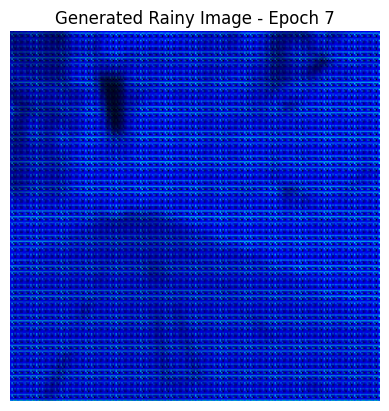

Epoch 8, Batch 1, Loss D: 0.0192, Loss G: 5.0251
Epoch 8, Batch 2, Loss D: 0.7284, Loss G: 12.9722
Epoch 8, Batch 3, Loss D: 0.4551, Loss G: 13.3430
Epoch 8, Batch 4, Loss D: 0.4659, Loss G: 9.5294
Epoch 8, Batch 5, Loss D: 0.1344, Loss G: 6.0120
Epoch 8, Batch 6, Loss D: 0.0165, Loss G: 3.6855


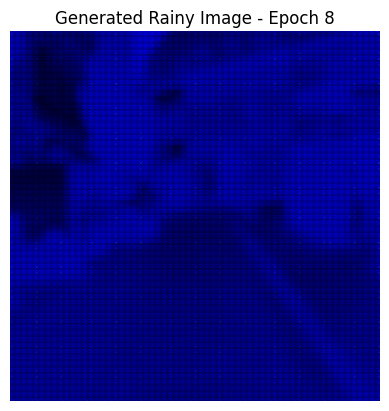

Epoch 9, Batch 1, Loss D: 0.0273, Loss G: 3.1062
Epoch 9, Batch 2, Loss D: 0.0545, Loss G: 4.0498
Epoch 9, Batch 3, Loss D: 0.0306, Loss G: 4.4603
Epoch 9, Batch 4, Loss D: 0.0284, Loss G: 4.2888
Epoch 9, Batch 5, Loss D: 0.0216, Loss G: 4.1035
Epoch 9, Batch 6, Loss D: 0.0829, Loss G: 3.5144


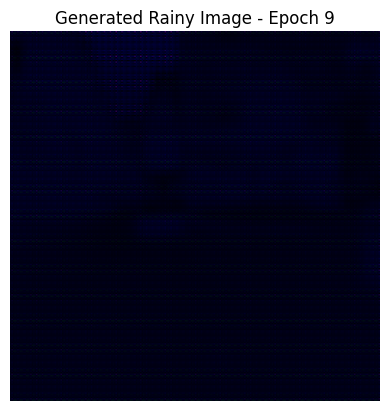

Epoch 10, Batch 1, Loss D: 0.0277, Loss G: 3.4969
Epoch 10, Batch 2, Loss D: 0.0357, Loss G: 3.6026
Epoch 10, Batch 3, Loss D: 0.0266, Loss G: 3.7647
Epoch 10, Batch 4, Loss D: 0.0985, Loss G: 3.2639
Epoch 10, Batch 5, Loss D: 0.0282, Loss G: 3.2851
Epoch 10, Batch 6, Loss D: 0.0227, Loss G: 3.6011


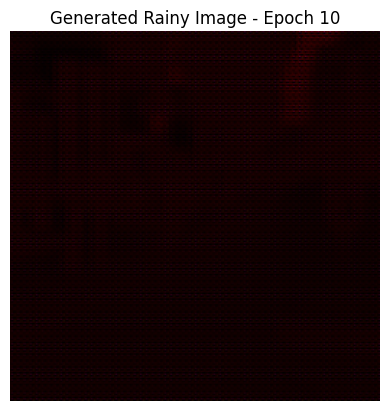

Epoch 11, Batch 1, Loss D: 0.0323, Loss G: 3.6737
Epoch 11, Batch 2, Loss D: 0.0188, Loss G: 3.8294
Epoch 11, Batch 3, Loss D: 0.0388, Loss G: 3.5615
Epoch 11, Batch 4, Loss D: 0.0175, Loss G: 3.8341
Epoch 11, Batch 5, Loss D: 0.0151, Loss G: 4.0195
Epoch 11, Batch 6, Loss D: 0.1682, Loss G: 3.1150


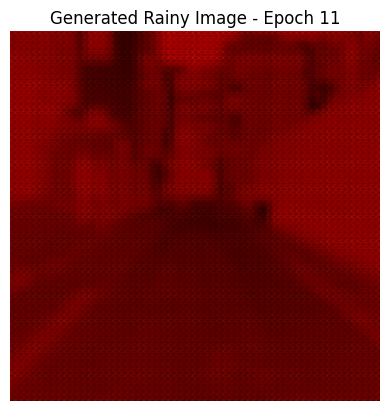

Epoch 12, Batch 1, Loss D: 0.0645, Loss G: 3.4034
Epoch 12, Batch 2, Loss D: 0.0963, Loss G: 4.6351
Epoch 12, Batch 3, Loss D: 0.1662, Loss G: 5.1095
Epoch 12, Batch 4, Loss D: 0.2866, Loss G: 5.9755
Epoch 12, Batch 5, Loss D: 0.2581, Loss G: 5.4619
Epoch 12, Batch 6, Loss D: 0.3850, Loss G: 11.6020


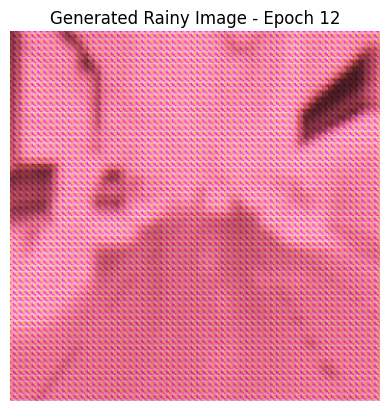

Epoch 13, Batch 1, Loss D: 0.3552, Loss G: 11.6012
Epoch 13, Batch 2, Loss D: 0.3572, Loss G: 9.4180
Epoch 13, Batch 3, Loss D: 0.1302, Loss G: 6.8248
Epoch 13, Batch 4, Loss D: 0.1828, Loss G: 3.6482
Epoch 13, Batch 5, Loss D: 0.0252, Loss G: 2.7181
Epoch 13, Batch 6, Loss D: 0.0685, Loss G: 4.4492


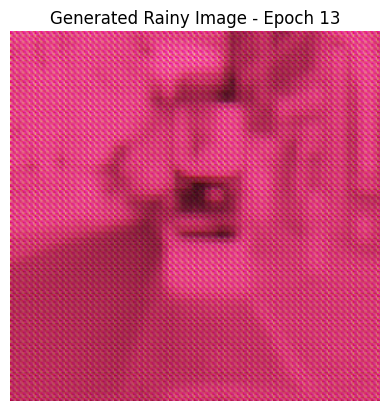

Epoch 14, Batch 1, Loss D: 0.0319, Loss G: 4.6999
Epoch 14, Batch 2, Loss D: 0.0393, Loss G: 4.2271
Epoch 14, Batch 3, Loss D: 0.0212, Loss G: 4.1146
Epoch 14, Batch 4, Loss D: 0.1578, Loss G: 3.6359
Epoch 14, Batch 5, Loss D: 0.0447, Loss G: 3.6348
Epoch 14, Batch 6, Loss D: 0.0262, Loss G: 3.9205


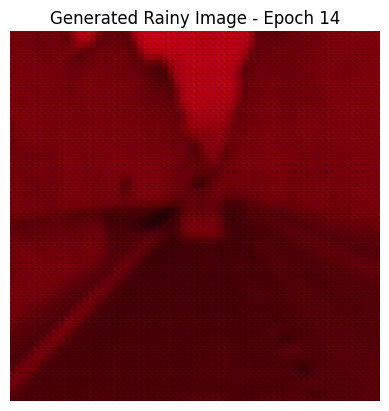

Epoch 15, Batch 1, Loss D: 0.0818, Loss G: 3.6050
Epoch 15, Batch 2, Loss D: 0.0195, Loss G: 3.7572
Epoch 15, Batch 3, Loss D: 0.1225, Loss G: 3.4186
Epoch 15, Batch 4, Loss D: 0.0467, Loss G: 3.3623
Epoch 15, Batch 5, Loss D: 0.0215, Loss G: 3.9277
Epoch 15, Batch 6, Loss D: 0.1704, Loss G: 3.7616


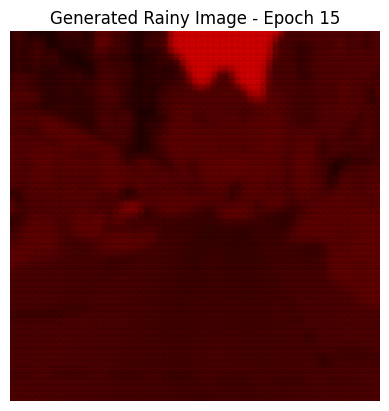

Epoch 16, Batch 1, Loss D: 0.0754, Loss G: 3.7341
Epoch 16, Batch 2, Loss D: 0.0486, Loss G: 3.7517
Epoch 16, Batch 3, Loss D: 0.0609, Loss G: 3.5395
Epoch 16, Batch 4, Loss D: 0.0433, Loss G: 4.2233
Epoch 16, Batch 5, Loss D: 0.0193, Loss G: 4.8195
Epoch 16, Batch 6, Loss D: 0.1761, Loss G: 5.1228


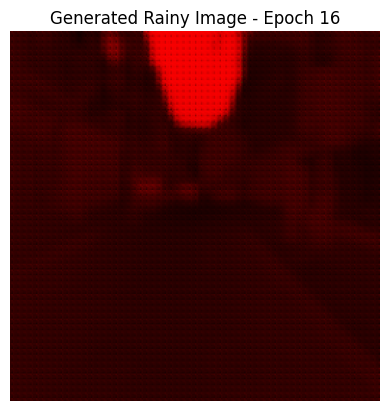

Epoch 17, Batch 1, Loss D: 0.0615, Loss G: 4.7294
Epoch 17, Batch 2, Loss D: 0.0124, Loss G: 4.8909
Epoch 17, Batch 3, Loss D: 0.0293, Loss G: 5.1272
Epoch 17, Batch 4, Loss D: 0.3721, Loss G: 8.8812
Epoch 17, Batch 5, Loss D: 0.1302, Loss G: 9.3817
Epoch 17, Batch 6, Loss D: 0.3859, Loss G: 6.1408


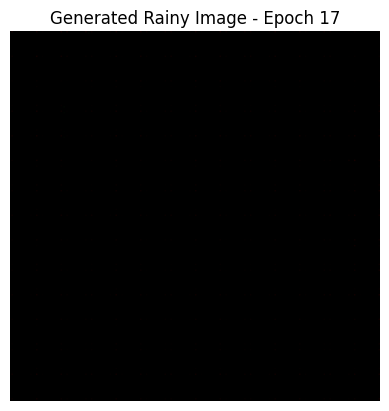

Epoch 18, Batch 1, Loss D: 0.6194, Loss G: 8.5862
Epoch 18, Batch 2, Loss D: 0.4654, Loss G: 11.8124
Epoch 18, Batch 3, Loss D: 2.1254, Loss G: 0.6859
Epoch 18, Batch 4, Loss D: 44.6949, Loss G: 0.0053
Epoch 18, Batch 5, Loss D: 50.0000, Loss G: 0.0000
Epoch 18, Batch 6, Loss D: 50.0001, Loss G: 0.0000


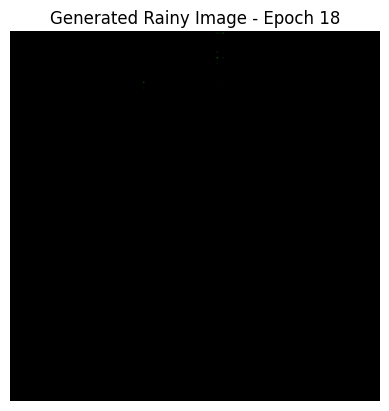

Epoch 19, Batch 1, Loss D: 50.0000, Loss G: 0.0000
Epoch 19, Batch 2, Loss D: 50.0000, Loss G: 0.0000
Epoch 19, Batch 3, Loss D: 50.0000, Loss G: 0.0000
Epoch 19, Batch 4, Loss D: 50.0000, Loss G: 0.0000
Epoch 19, Batch 5, Loss D: 50.0000, Loss G: 0.0000
Epoch 19, Batch 6, Loss D: 50.0000, Loss G: 0.0000


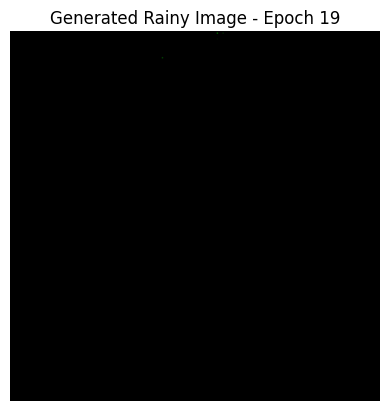

Epoch 20, Batch 1, Loss D: 50.0000, Loss G: 0.0000
Epoch 20, Batch 2, Loss D: 50.0000, Loss G: 0.0000
Epoch 20, Batch 3, Loss D: 50.0000, Loss G: 0.0000
Epoch 20, Batch 4, Loss D: 50.0000, Loss G: 0.0000
Epoch 20, Batch 5, Loss D: 50.0000, Loss G: 0.0000
Epoch 20, Batch 6, Loss D: 50.0000, Loss G: 0.0000


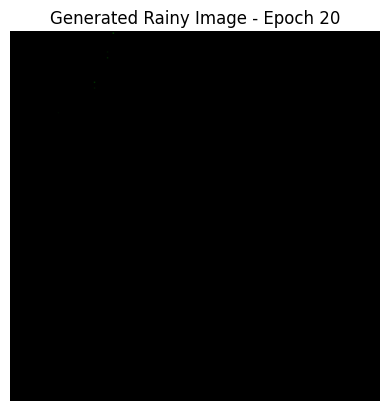

Epoch 21, Batch 1, Loss D: 50.0000, Loss G: 0.0000
Epoch 21, Batch 2, Loss D: 50.0000, Loss G: 0.0000
Epoch 21, Batch 3, Loss D: 50.0000, Loss G: 0.0000
Epoch 21, Batch 4, Loss D: 50.0000, Loss G: 0.0000
Epoch 21, Batch 5, Loss D: 50.0000, Loss G: 0.0000
Epoch 21, Batch 6, Loss D: 50.0000, Loss G: 0.0000


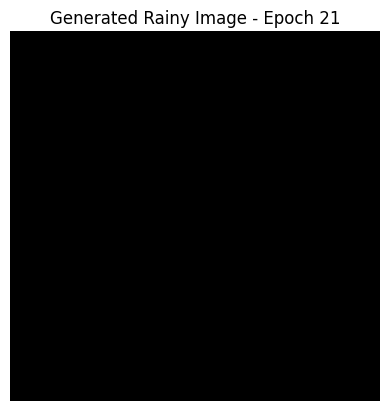

Epoch 22, Batch 1, Loss D: 50.0000, Loss G: 0.0000
Epoch 22, Batch 2, Loss D: 50.0000, Loss G: 0.0000
Epoch 22, Batch 3, Loss D: 50.0000, Loss G: 0.0000
Epoch 22, Batch 4, Loss D: 50.0000, Loss G: 0.0000
Epoch 22, Batch 5, Loss D: 50.0000, Loss G: 0.0000
Epoch 22, Batch 6, Loss D: 50.0000, Loss G: 0.0000


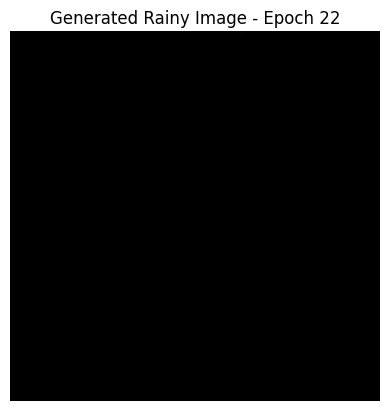

Epoch 23, Batch 1, Loss D: 50.0000, Loss G: 0.0000
Epoch 23, Batch 2, Loss D: 50.0000, Loss G: 0.0000
Epoch 23, Batch 3, Loss D: 50.0000, Loss G: 0.0000
Epoch 23, Batch 4, Loss D: 50.0000, Loss G: 0.0000
Epoch 23, Batch 5, Loss D: 50.0000, Loss G: 0.0000
Epoch 23, Batch 6, Loss D: 50.0000, Loss G: 0.0000


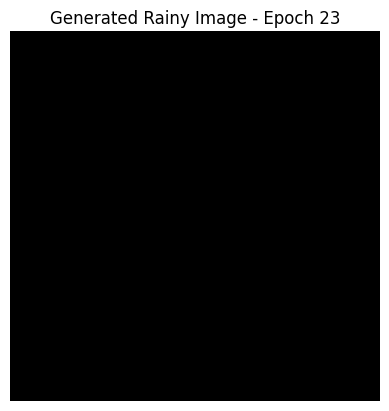

Epoch 24, Batch 1, Loss D: 50.0000, Loss G: 0.0000
Epoch 24, Batch 2, Loss D: 50.0000, Loss G: 0.0000
Epoch 24, Batch 3, Loss D: 50.0000, Loss G: 0.0000
Epoch 24, Batch 4, Loss D: 50.0000, Loss G: 0.0000
Epoch 24, Batch 5, Loss D: 50.0000, Loss G: 0.0000
Epoch 24, Batch 6, Loss D: 50.0000, Loss G: 0.0000


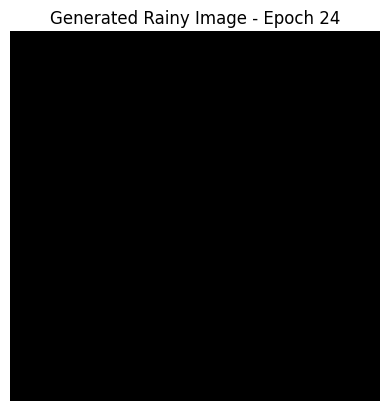

KeyboardInterrupt: 

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Check for multiple GPUs
device_count = torch.cuda.device_count()
device = torch.device("cuda:0" if device_count > 0 else "cpu")

# Print GPU status
if device_count > 1:
    print(f"Using {device_count} GPUs!")
else:
    print("Using a single GPU or CPU.")

# Dataset class for loading images
class RainDataset(Dataset):
    def __init__(self, clear_image_dir, rainy_image_dir, transform=None):
        self.clear_image_dir = clear_image_dir
        self.rainy_image_dir = rainy_image_dir
        self.transform = transform
        self.clear_images = [f for f in os.listdir(clear_image_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
        self.rainy_images = [f for f in os.listdir(rainy_image_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
        
        min_size = min(len(self.clear_images), len(self.rainy_images))
        self.clear_images = self.clear_images[:min_size]
        self.rainy_images = self.rainy_images[:min_size]

    def __len__(self):
        return len(self.clear_images)

    def __getitem__(self, index):
        clear_image_path = os.path.join(self.clear_image_dir, self.clear_images[index])
        rainy_image_path = os.path.join(self.rainy_image_dir, self.rainy_images[index])

        clear_image = cv2.imread(clear_image_path)
        rainy_image = cv2.imread(rainy_image_path)

        clear_image = cv2.cvtColor(clear_image, cv2.COLOR_BGR2RGB)
        rainy_image = cv2.cvtColor(rainy_image, cv2.COLOR_BGR2RGB)

        if self.transform:
            clear_image = self.transform(clear_image)
            rainy_image = self.transform(rainy_image)

        return clear_image, rainy_image


# Generator: Adds rain to the input clear image
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3),
            nn.Tanh(),  # Output with values between -1 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = nn.functional.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)  # Resize to match input size
        return x


# Discriminator: Determines if an image is real or fake
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_input_size = self._get_fc_input_size(256)  # Assuming input size 256x256
        self.fc = nn.Linear(self.fc_input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def _get_fc_input_size(self, image_size):
        dummy_input = torch.zeros(1, 6, image_size, image_size)
        output = self.model(dummy_input)
        return output.view(1, -1).size(1)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


# Initialize models and move to GPU
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Use DataParallel if multiple GPUs are available
if device_count > 1:
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)

# Loss functions and optimizers
criterion = nn.BCELoss()

# Modify learning rate and optimizer settings
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Weight initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

generator.apply(weights_init)

# Dataset and DataLoader setup
clear_image_dir = "/kaggle/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/train/aachen"
rainy_image_dir = "/kaggle/input/weather-dataset/dataset/rain"
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])
dataset = RainDataset(clear_image_dir, rainy_image_dir, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training loop
for epoch in range(100):  # Total epochs
    for i, (clear_images, rainy_images) in enumerate(dataloader):
        clear_images, rainy_images = clear_images.to(device), rainy_images.to(device)

        # Train Discriminator with real images (clear + rainy)
        real_images = torch.cat((clear_images, rainy_images), 1)
        labels_real = torch.ones(clear_images.size(0), 1).to(device)
        outputs_real = discriminator(real_images)
        loss_d_real = criterion(outputs_real.view(-1), labels_real.view(-1))

        # Train Discriminator with fake images (generated rainy images)
        fake_rain = generator(clear_images)
        fake_images = torch.cat((clear_images, fake_rain.detach()), 1)
        labels_fake = torch.zeros(clear_images.size(0), 1).to(device)
        outputs_fake = discriminator(fake_images)
        loss_d_fake = criterion(outputs_fake.view(-1), labels_fake.view(-1))

        # Total Discriminator loss
        loss_d = (loss_d_real + loss_d_fake) / 2
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        # Train Generator to fool Discriminator
        fake_images = torch.cat((clear_images, fake_rain), 1)
        labels_fake = torch.ones(clear_images.size(0), 1).to(device)
        outputs_fake = discriminator(fake_images)
        loss_g = criterion(outputs_fake.view(-1), labels_fake.view(-1))
        
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        # Print losses for each batch
        print(f"Epoch {epoch+1}, Batch {i+1}, Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

    # Save model checkpoints after each epoch
    torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
    torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")

    # Generate and plot an example generated image after each epoch
    with torch.no_grad():
        sample_image = generator(clear_images[:1].to(device))  # Generate a sample image
        sample_image = sample_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convert to numpy for display

        # Display the generated image using matplotlib
        plt.imshow(sample_image)
        plt.title(f"Generated Rainy Image - Epoch {epoch+1}")
        plt.axis('off')
        plt.show()
